In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
# from torchvision.models import resnet50, swin_v2_b
from transformers import AutoFeatureExtractor, AutoImageProcessor, ViTForImageClassification

# Transfer Learning with a Pre-Trained Vision Transformer
- Freeze all layers of the pre-trained model as a feature extractor
- Train a new classification head by combining a `nn.Linear` and `nn.Softmax`

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Ingestion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "/content/drive/Othercomputers/My MacBook Pro 2021/Documents/ai-image-detection/root"
# root_path = "/content/drive/Othercomputers/My MacBook Pro 2021/Documents/Cornell/CS 5787/CS 5787 - Final Project/data/root"

In [ ]:
def load_dalle(feature_extractor, BATCH_SIZE):

    # AutoFeatureExtractor
    def transform(image):
        return feature_extractor(image, return_tensors='pt')['pixel_values'].squeeze()
    
    ds = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

    # 80/20 train-test split
    ds_train, ds_test = torch.utils.data.random_split(ds, lengths=[round(0.8 * len(ds)), round(0.2 * len(ds))])

    # DataLoaders: loads and shuffles the training dataset in mini-batches
    train_loader = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)
    
    return ds, train_loader, test_loader

In [ ]:
# Load dataset
ds, train_loader, test_loader = load_dalle(AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224"), 64)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
class_counts = pd.Series(ds.targets).value_counts().to_frame('n_samples')
class_counts['class'] = class_counts.index.map({k:v for v, k in ds.class_to_idx.items()})
class_counts

,n_samples,class
0,1000,class_control
1,1000,class_dalle
2,1000,class_midjourney
3,1000,class_stable_diffusion


## Model Initialization

Create a hook to save the output of the last hidden layer (in this case linear layer)

In [ ]:
from transformers import SwinModel

In [ ]:
modelSwin = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
modelSwin = modelSwin.to(DEVICE)

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Transfer Learning

In [ ]:
# Create a class with up to final linear layer
# Add a linear and softmax
class AiImageDetector(nn.Module):

    def __init__(self, model, freeze_input_model_layers=True):
        
        super().__init__()

        # Create a class with up to final linear layer
        self.pipeline = model

        # Freeze the Swin model
        if freeze_input_model_layers:
            for param in self.pipeline.parameters():
                param.requires_grad = False
        
        # Classifier layer that actually trained
        self.clf = nn.Sequential(
            nn.Linear(768, 4),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.pipeline(x)['pooler_output']
        # x = torch.flatten(x, 1)
        x = self.clf(x)

        return x

### Training

In [ ]:
def train_classifier(model, N_EPOCHS = 50):

    # Initialize the model, optimizer, and loss function
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    # Training loop
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(DEVICE)
    train_loss_list = []

    for epoch in tqdm(range(N_EPOCHS)):
        train_loss = 0.0
        for images, labels in train_loader:
            # Move the images and labels to the device (GPU or CPU) that the model is being trained on.
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # clear gradients before each new backward pass
            optimizer.zero_grad()
            # Forward pass
            outputs = model(images)
            # Compute cost
            loss = loss_fn(outputs, labels)
            # Backward pass to upgdate gradients with autograd
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Avg. training loss for the epoch
        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        print(f'Epoch {epoch + 1}/{N_EPOCHS} || Loss: {train_loss:.6f}')
    
    return train_loss_list

In [ ]:
def plot_train_loss(train_loss_list):
    # Plot training loss
    plt.plot(train_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('TRAINING LOSS AS FUNCTION OF EPOCHS')
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 || Loss: 1.197710
Epoch 2/50 || Loss: 1.030826
Epoch 3/50 || Loss: 0.971094
Epoch 4/50 || Loss: 0.937381
Epoch 5/50 || Loss: 0.913925
Epoch 6/50 || Loss: 0.897152
Epoch 7/50 || Loss: 0.884060
Epoch 8/50 || Loss: 0.873450
Epoch 9/50 || Loss: 0.864721
Epoch 10/50 || Loss: 0.857568
Epoch 11/50 || Loss: 0.851309
Epoch 12/50 || Loss: 0.846079
Epoch 13/50 || Loss: 0.841228
Epoch 14/50 || Loss: 0.836971
Epoch 15/50 || Loss: 0.833162
Epoch 16/50 || Loss: 0.829940
Epoch 17/50 || Loss: 0.826623
Epoch 18/50 || Loss: 0.823444
Epoch 19/50 || Loss: 0.820628
Epoch 20/50 || Loss: 0.818266
Epoch 21/50 || Loss: 0.815955
Epoch 22/50 || Loss: 0.813665
Epoch 23/50 || Loss: 0.811654
Epoch 24/50 || Loss: 0.809755
Epoch 25/50 || Loss: 0.807695
Epoch 26/50 || Loss: 0.805916
Epoch 27/50 || Loss: 0.804196
Epoch 28/50 || Loss: 0.802624
Epoch 29/50 || Loss: 0.801242
Epoch 30/50 || Loss: 0.799740
Epoch 31/50 || Loss: 0.798514
Epoch 32/50 || Loss: 0.797244
Epoch 33/50 || Loss: 0.796156
Epoch 34/50 || Loss

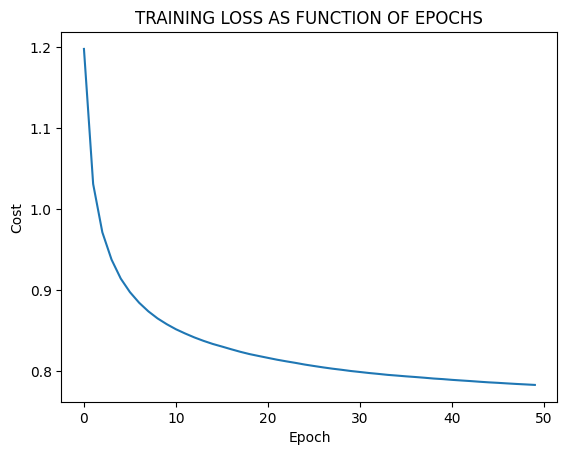

In [ ]:
model = AiImageDetector(modelSwin, freeze_input_model_layers=True)
model_loss = train_classifier(model, N_EPOCHS=50)
plot_train_loss(model_loss)


torch.save(model, '/'.join(root_path.split('/')[:-1]) + "/swin_transfer_learn_frozen.pt")

### Testing

In [ ]:
def test_classifier(model, test_loader):
    correct = 0
    total = 0
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_test = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)

            # Store y_test and y_pred
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'TEST DATA ACCURACY: {test_accuracy:.2f}%')

    return np.array(y_test), np.array(y_pred)

In [ ]:
y_test, y_pred = test_classifier(model, test_loader)

  0%|          | 0/13 [00:00<?, ?it/s]

TEST DATA ACCURACY: 87.25%


### Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
class_counts

,n_samples,class
0,1000,class_control
1,1000,class_dalle
2,1000,class_midjourney
3,1000,class_stable_diffusion


In [ ]:
print(classification_report(y_test, y_pred))
print("Mean-per-class accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       207
           1       0.85      0.81      0.83       203
           2       0.83      0.89      0.86       201
           3       0.86      0.90      0.88       189

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800

Mean-per-class accuracy: 0.8725


Text(0.5, 1.0, 'Confusion Matrix: Swin Transformer')

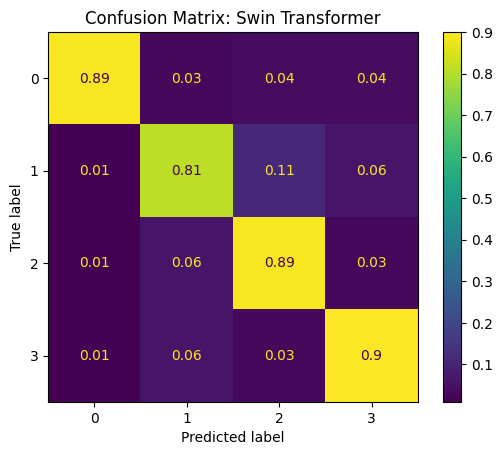

In [ ]:
cm = np.round((confusion_matrix(y_test, y_pred, normalize = "true")),2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix: Swin Transformer')